# Telco Customer Churn & Growth Analytics
This notebook walks through:
1. **EDA** of the Telco Customer Churn dataset
2. **Cohort & Retention Analysis**
3. **Funnel Analysis**
4. **Simulated A/B Test**
5. **Churn Prediction Model**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style='whitegrid')

In [9]:
# 1. Load Telco Customer Churn dataset
df = pd.read_csv("telco_customer_churn.csv")

# Dataset shape and info
print('Shape:', df.shape)
print(df.info())

#Check first five rows
df.head()

Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1. Exploratory Data Analysis (EDA)
Load data, inspect shape, missing values, and basic distributions.

In [11]:
# Check for missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### 1.1 Churn Distribution and Feature Relationships

#### Churn:
The churn rate is the percentage of customers or subscribers that discontinue their relationship with a business over a specific period.

Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Percentage:
Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64


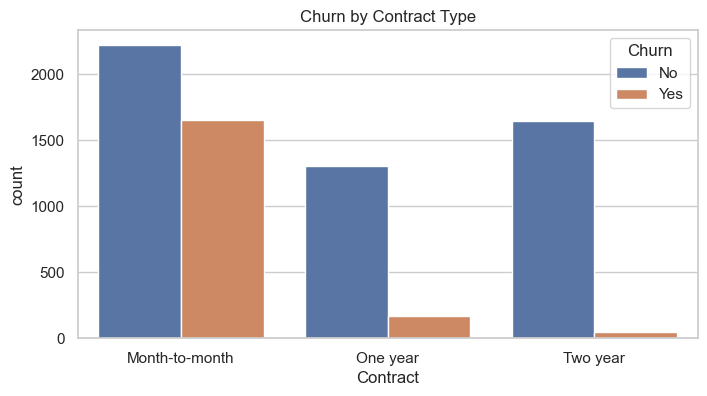

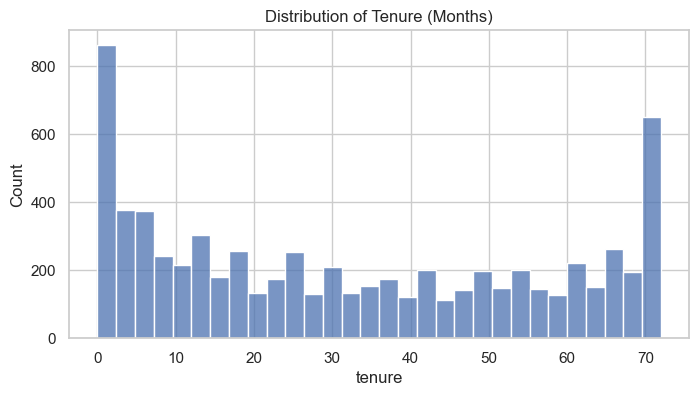

In [13]:
# Churn count and percentage
churn_counts = df['Churn'].value_counts()
print(churn_counts)
print('\nChurn Percentage:')
print(churn_counts / df.shape[0] * 100)

# Visualise churn by contract type
plt.figure(figsize=(8, 4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.show()

# Tenure distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['tenure'], bins=30, kde=False)
plt.title('Distribution of Tenure (Months)')
plt.show()

## 2. Cohort & Retention Analysis
Define cohorts based on the month of signup (using 'tenure'), and track retention over time.

In [19]:
# Convert 'Churn' to numeric flag
df['Churn_flag'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Simulate 'signup_date' assuming today's date is '2020-02-01' and using 'tenure' backwards
import datetime as dt
reference_date = pd.to_datetime('2020-02-01')

# Approximate months as 30 days and calculate 'signup_date'
df['signup_date'] = reference_date - pd.to_timedelta(df['tenure'] * 30, unit='D')

# Extract signup month
df['signup_month'] = df['signup_date'].dt.to_period('M')

# Compute retention: 'still_active' if Churn_flag == 0
cohort_data = df.groupby('signup_month').agg(
    total_customers=('customerID', 'count'),
    retained=('Churn_flag', lambda x: (x == 0).sum())
).reset_index()

# Calculate retention rate
cohort_data['retention_rate'] = cohort_data['retained'] / cohort_data['total_customers']

# Show the cohort data with retention rates
cohort_data

,signup_month,total_customers,retained,retention_rate
0,2014-03,362,356,0.983425
1,2014-04,170,164,0.964706
2,2014-05,119,108,0.907563
3,2014-06,95,87,0.915789
4,2014-07,100,91,0.910000
...,...,...,...,...
67,2019-10,176,93,0.528409
68,2019-11,200,106,0.530000
69,2019-12,238,115,0.483193
70,2020-01,613,233,0.380098


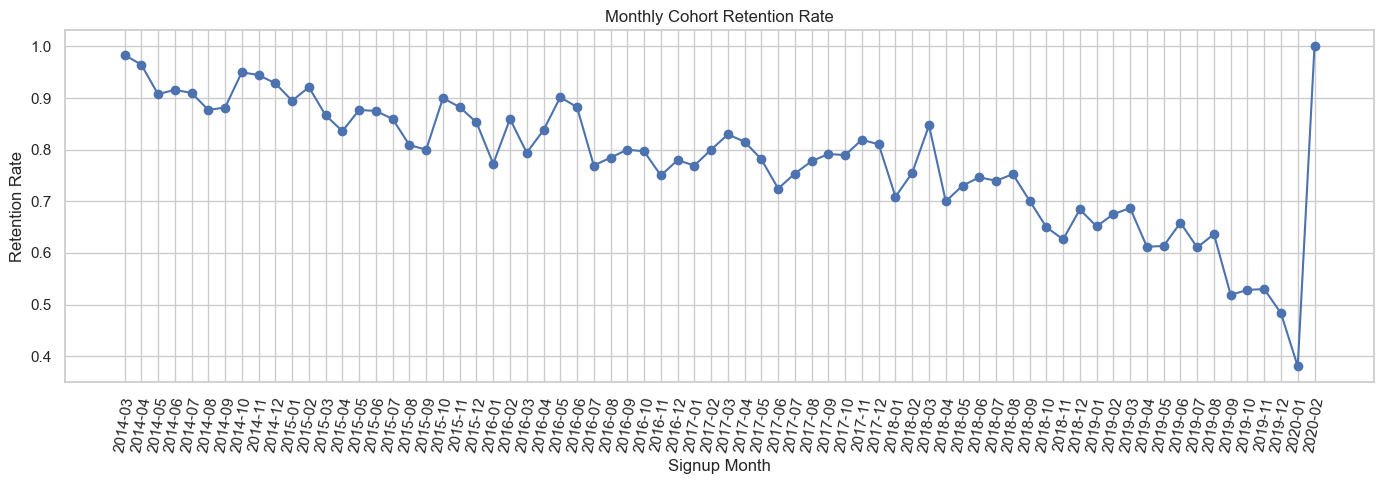

In [37]:
# Plot cohort retention rate
plt.figure(figsize=(14, 5))
plt.plot(cohort_data['signup_month'].astype(str), cohort_data['retention_rate'], marker='o')
plt.xticks(rotation=80)
plt.title('Monthly Cohort Retention Rate')
plt.xlabel('Signup Month')
plt.ylabel('Retention Rate')
plt.tight_layout()
plt.show()

## 3. Funnel Analysis
Simulate a user funnel:
1. Signed Up
2. Has Internet Service
3. Uses Streaming TV or Movies
4. Still Active
Compute stepwise conversion rates.

In [39]:
# Step 1: Total signed up (all customers)
total_signed = df.shape[0]

# Step 2: Has Internet Service != 'No'
has_internet = df[df['InternetService'] != 'No'].shape[0]

# Step 3: Uses StreamingTV or StreamingMovies
streaming = df[(df['StreamingTV'] == 'Yes') | (df['StreamingMovies'] == 'Yes')].shape[0]

# Step 4: Still active (Churn_flag == 0)
still_active = df[df['Churn_flag'] == 0].shape[0]

funnel = pd.DataFrame({
    'Step': [
        'Signed Up', 'Has Internet', 'Uses Streaming', 'Still Active'
    ],
    'Count': [
        total_signed, has_internet, streaming, still_active
    ]
})
funnel['Conversion'] = funnel['Count'] / total_signed
funnel

,Step,Count,Conversion
0,Signed Up,7043,1.000000
1,Has Internet,5517,0.783331
2,Uses Streaming,3499,0.496805
3,Still Active,5174,0.734630


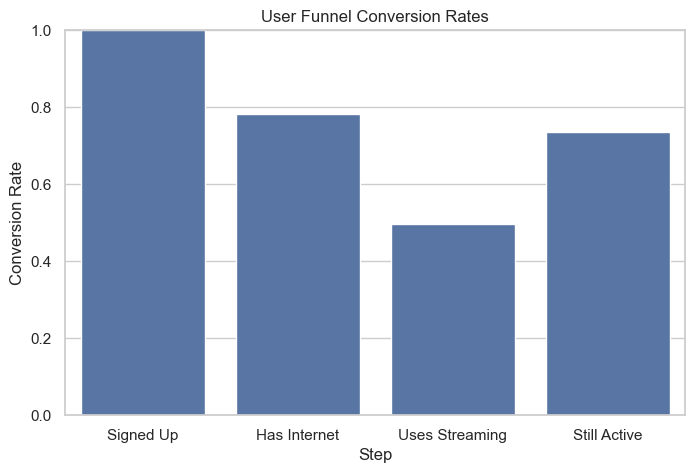

In [41]:
# Plot funnel conversion rates
plt.figure(figsize=(8, 5))
sns.barplot(x='Step', y='Conversion', data=funnel)
plt.ylim(0, 1)
plt.title('User Funnel Conversion Rates')
plt.ylabel('Conversion Rate')
plt.show()

## 4. Simulated A/B Test
Randomize 'monthly_contract' customers into Control (A) and Treatment (B). Simulate a retention campaign that reduces churn for Treatment.

In [43]:
# Filter month-to-month customers
mtm = df[df['Contract'] == 'Month-to-month'].copy()
mtm['group'] = np.random.choice(['A', 'B'], size=mtm.shape[0], replace=True)

# Baseline churn counts for each group
grouped = mtm.groupby('group')['Churn_flag'].agg(
    total='count',
    churned='sum'
).reset_index()
grouped['rate'] = grouped['churned'] / grouped['total']
grouped

,group,total,churned,rate
0,A,1896,800,0.421941
1,B,1979,855,0.432036


In [47]:
# Simulate treatment effect: reduce churn to zero in group B (for demonstration)
mtm_effect = mtm.copy()
mtm_effect.loc[mtm_effect['group'] == 'B', 'Churn_flag'] = 0

# Recompute counts after treatment
grouped_effect = mtm_effect.groupby('group')['Churn_flag'].agg(
    total='count',
    churned='sum'
).reset_index()
grouped_effect['rate'] = grouped_effect['churned'] / grouped_effect['total']
grouped_effect

,group,total,churned,rate
0,A,1896,800,0.421941
1,B,1979,0,0.000000


In [49]:
# Perform two-sample z-test on churn proportions
count = grouped_effect['churned'].values
nobs = grouped_effect['total'].values
stat, pval = proportions_ztest(count, nobs)
print(f'z-statistic: {stat:.3f}')
print(f'p-value: {pval:.4f}')

z-statistic: 32.439
p-value: 0.0000


## 5. Churn Prediction Model
Train a Logistic Regression to predict churn, evaluate performance.

In [51]:
# Select features and encode where necessary
features = ['SeniorCitizen', 'tenure', 'MonthlyCharges']
X = df[features]
y = df['Churn_flag']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predictions & evaluation
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))

ROC AUC: 0.838994586313621

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.69      0.48      0.57       373

    accuracy                           0.81      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.81      0.79      1409


Confusion Matrix:
 [[956  80]
 [194 179]]


ROC AUC: 0.754159895245686
Accuracy: 0.680624556422995
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      1036
           1       0.43      0.65      0.52       373

    accuracy                           0.68      1409
   macro avg       0.64      0.67      0.64      1409
weighted avg       0.74      0.68      0.70      1409



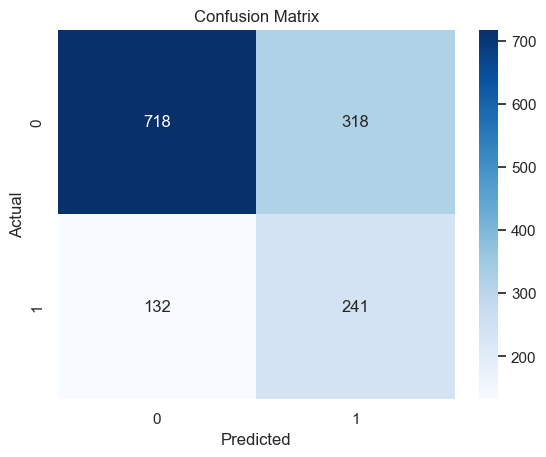

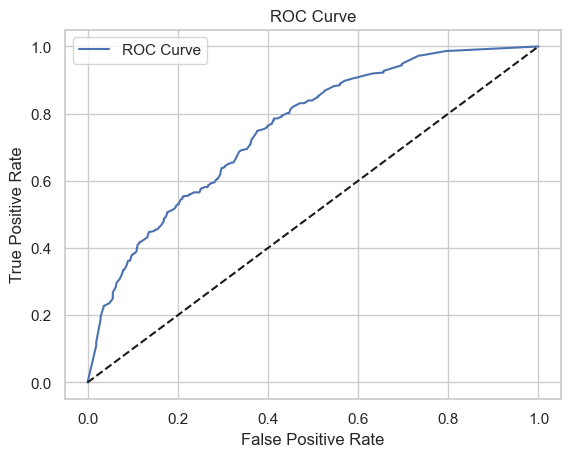

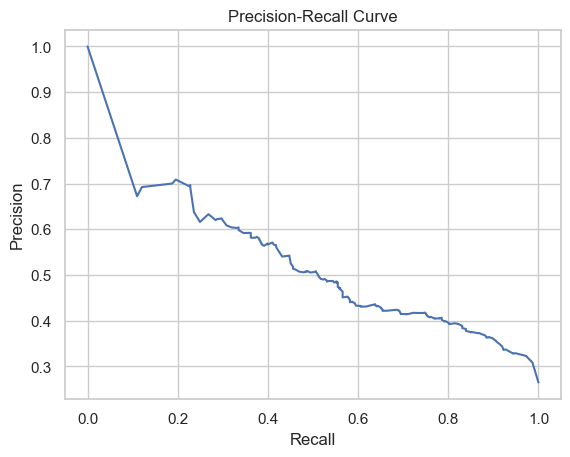

In [58]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Balance the training set with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on test set
y_probs = rf.predict_proba(X_test)[:, 1]

# Threshold tuning
threshold = 0.4
y_pred_adjusted = (y_probs >= threshold).astype(int)

# Metrics
print("ROC AUC:", roc_auc_score(y_test, y_probs))
print("Accuracy:", accuracy_score(y_test, y_pred_adjusted))
print(classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_probs)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()
